This is a general purpose image classifer using transfer learning (based on MobileNet model), with some helper methods.

In [1]:
import tensorflow as tf
tf.__version__

'2.1.0'

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization, Flatten, add
from tensorflow.keras.layers import GlobalAveragePooling2D,AveragePooling2D,DepthwiseConv2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.applications import imagenet_utils, mobilenet_v2

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.layers import Input
from tensorflow.keras.utils import to_categorical

import numpy as np
import matplotlib.pyplot as plt
import time
import os

In [3]:
# set ansi color values
Cblu ='\33[34m'
Cend='\33[0m'   # sets color back to default 
Cred='\033[91m'
Cblk='\33[39m'
Cgreen='\33[32m'
Cyellow='\33[33m'

## get_Paths() function

This function defines the paths for the data. it has an mode argument, when mode=ALL it takes all the data from a single directory, when the mode is not ALL it assumes the data is seperated into training , validation and testing set.

In [4]:
def get_paths(source_dir,output_dir,mode,subject):
    
    if mode =='ALL':
        # all data is in a single directory must be split into train, test, valid data sets        
        train_path=os.path.join(t_path,'train ')    
        classes=os.listdir(train_path) 
        class_num=len(classes)
        test_path=None        
        valid_path=None
       
    else:
        # data is seperated in 3 directories train, test, valid
        valid_path=r'./seg_test/seg_test'
        train_path=r'./seg_train/seg_train'
        test_path =r'./seg_pred/'
        classes=os.listdir(train_path)
        print('classes are ',classes)
        output_dir=r'./working'
        class_num=len(classes)    
    # save the class dictionary as a text file so it can be used by predictor.py in the future
    #saves file as subject.txt  structure is similar to a python dictionary
    msg=''
    for i in range(0, class_num):
        msg=msg + str(i) + ':' + classes[i] +','
    id=subject  + '.txt'   
    dict_path=os.path.join (output_dir, id)
    f=open(dict_path, 'w')
    f.write(msg)
    f.close()    
    return [train_path, test_path, valid_path,classes]

## make_model() function

make_model() function makes the model based on the selection of the model size. model_size='L' selects the large model which is based on transfer learning for MobileNet. MobileNet works best when the image size is selected as 224 X 224 because it is then possible to load the pre-trained imagenet weights. If the image size is not 224 X 224 the imagenet weights can not be used. Therefore the weights are randomly initialized and it takes many epochs of training to get up to a desireable level of training accuracy. If model_size='M' a medium sized model is used. It is faster for computation but less accurate then the large model. If model_size='S' a small model is used. Again it is less accurate than the medium and large models but has significantly less computations.

In [5]:
def make_model(classes,lr_rate, height,width,model_size, rand_seed):
    size=len(classes)
    #check_file = os.path.join(output_dir, 'tmp.h5')
    
    if model_size=='V1':
        if height != 224 or width != 224:
            Top=False
            weights='imagenet'
            layer_cut=-1
        else:
            Top=True
            weights='imagenet'
            layer_cut=-6  
        mobile = tf.keras.applications.mobilenet.MobileNet( include_top=Top,
                                                           input_shape=(height,width,3),
                                                           pooling='avg', weights=weights,
                                                           alpha=1, depth_multiplier=1)
        x=mobile.layers[layer_cut].output
        x=Dense(256, kernel_regularizer = regularizers.l2(l = 0.015), activation='relu')(x)
        x=Dropout(rate=.5, seed=rand_seed)(x)
        x=Dense(64, kernel_regularizer = regularizers.l2(l = 0.015), activation='relu')(x)
        x=Dropout(rate=.5, seed=rand_seed)(x)
        predictions=Dense (size, activation='softmax')(x)
        model = Model(inputs=mobile.input, outputs=predictions)        
        for layer in model.layers:
            layer.trainable=True
        model.compile(Adam(lr=lr_rate), loss='categorical_crossentropy', metrics=['accuracy'])
        
    else:
        if model_size=='V2':
            if height == 224 and width == 224:
                Top=False               
                #model = tf.keras.applications.MobileNetV2(input_shape=(width, height,3),classes= size, weight_decay=.015, feat_dropout=.5, input_tensor=None)
                #x = tf.keras.applications.MobileNetV2(input_shape=(160, 160, 3),   include_top=False)                 
                base_model=tf.keras.applications.MobileNetV2( input_shape=( height,width,3),
                                                             weights='imagenet',include_top=False) 
                x=base_model.output
                x=GlobalAveragePooling2D()(x)
                x=Dense(1024,activation='relu')(x)
                x=Dropout(rate=.5, seed=rand_seed)(x)
                preds=Dense(size,activation='softmax')(x)
                model=Model(inputs=base_model.input,outputs=preds)
            else:
                Top=True
                weights='imagenet'            
                x = tf.keras.applications.MobileNetV2()
                x=Dense(256, kernel_regularizer = regularizers.l2(l = 0.015), activation='relu')(x)
                x=Dropout(rate=.5, seed=rand_seed)(x)
                predictions=Dense (size, activation='softmax')(x)
                model = Model(inputs=mobile.input, outputs=predictions)   
                
        for layer in model.layers:
            layer.trainable=True
        model.compile(Adam(lr=lr_rate), loss='categorical_crossentropy', metrics=['accuracy'])
        model.summary()
    return model

## make_generators() function

Based on ImageDataGenerator built in Keras, generate images for model based on mode selected.

In [6]:
def make_generators( paths, mode, batch_size, v_split, classes, height, width):
    #paths[0]=train path,paths[1]=test path paths[2]= valid path paths[3]=classes
    v_split=v_split/100.0
    file_names=[]
    labels=[]    
    if mode != 'ALL':
        train_gen=ImageDataGenerator(preprocessing_function=keras.applications.mobilenet.preprocess_input,
                horizontal_flip=True,
                samplewise_center=True,
                width_shift_range=.2,
                height_shift_range=.2,
                validation_split=v_split,
                samplewise_std_normalization=True).flow_from_directory(paths[0], target_size=(height, width),
                batch_size=batch_size, seed=rand_seed)
        
        val_gen=ImageDataGenerator(preprocessing_function=keras.applications.mobilenet.preprocess_input,
                samplewise_center=True,                
                samplewise_std_normalization=True).flow_from_directory(paths[2], 
                target_size=(height, width), batch_size=batch_size,seed=rand_seed, shuffle=False)
        
        test_gen=ImageDataGenerator(preprocessing_function=keras.applications.mobilenet.preprocess_input,
                samplewise_center=True,                
                samplewise_std_normalization=True).flow_from_directory(paths[1],
                target_size=(height, width), batch_size=batch_size,seed=rand_seed, shuffle=False)
        for file in val_gen.filenames:# normal would use test_gen but in this case val set is the test set
            file_names.append(file)            
        #for label in test_gen.labels: test set has no labels use labels from validation set
            #labels.append(label)
        for label in val_gen.labels:
            labels.append(label)
        
        #return [train_gen, test_gen, val_gen, file_names, labels]
        return[train_gen, test_gen, val_gen, file_names,labels]
                  
    else:
        # all data is in a single directory there are no test images use validation images as test images
        train_gen=ImageDataGenerator(preprocessing_function=keras.applications.mobilenet.preprocess_input,
                             horizontal_flip=True,
                             samplewise_center=True,
                             validation_split=v_split,
                             samplewise_std_normalization=True).flow_from_directory(paths[0],
                                                                                    target_size=(height, width),
                                                                                    batch_size=batch_size,
                                                                                    subset='training',seed=rand_seed)
        val_gen=ImageDataGenerator(preprocessing_function=keras.applications.mobilenet.preprocess_input,
                             horizontal_flip=False,
                             samplewise_center=True,
                             validation_split=v_split,
                             samplewise_std_normalization=True).flow_from_directory(paths[0],
                                                                                    target_size=(height, width),
                                                                                    batch_size=batch_size,
                                                                                    subset='validation',
                                                                                    seed=rand_seed, shuffle=False)
        
        
        for file in val_gen.filenames:
            file_names.append(file)
        for label in val_gen.labels:
            labels.append(label)
    return [train_gen, val_gen,val_gen, file_names, labels]

## train() function

Initiate training process

In [7]:
def train(model, callbacks, train_gen, val_gen, epochs,start_epoch):
    start=time.time()
    data = model.fit_generator(generator = train_gen, validation_data= val_gen, epochs=epochs, initial_epoch=start_epoch,
                       callbacks = callbacks, verbose=1)
    stop=time.time()
    duration = stop-start
    hrs=int(duration/3600)
    mins=int((duration-hrs*3600)/60)
    secs= duration-hrs*3600-mins*60
    msg='{0}Training took\n {1} hours {2} minutes and {3:6.2f} seconds {4}'
    print(msg.format(Cblu,hrs, mins,secs,Cend))
    return data

## tr_plot() function

This function generates two plots: 1) training and validation loss versus epochs, 2) training and validation accuracy versus epochs.

In [8]:
def tr_plot(tacc,vacc,tloss,vloss):
    #Plot the training and validation data
    Epoch_count=len(tloss)
    Epochs=[]
    for i in range (0,Epoch_count):
        Epochs.append(i+1)
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    val_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1)
    vc_label='best epoch= '+ str(index_acc + 1)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(15,5))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1,val_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout
    #plt.style.use('fivethirtyeight')
    plt.show()

## save_model() function

This function is called at the end of the program. It saves the trained model to the output directory so it can be used with a companion prediction program. The model is saved with the title subject-height-width-model.txt where subject is the subject the user enetered, height and width are those set by the user, model is the model_size, L, M or S.

In [9]:
def save_model(output_dir,subject, accuracy, height, width, model, weights):
    # save the model with the  subect-accuracy.h5
    acc=str(accuracy)[0:5]
    tempstr=subject + '-' +str(height) + '-' + str(width) + '-' + acc + '.h5'
    model.set_weights(weights)
    model_save_path=os.path.join(output_dir,tempstr)
    model.save(model_save_path)    

## make_predictions() function

This function receives the model weights that were saved during training for the lowest validation loss. it then makes predictions on the test set. Note when the data set has no test set it makes predictions on the validation set

In [10]:
def make_predictions( model, weights, test_gen, lr):
    config = model.get_config()
    pmodel = Model.from_config(config)  # copy of the model
    pmodel.set_weights(weights) #load saved weights with lowest validation loss
    pmodel.compile(Adam(lr=lr), loss='categorical_crossentropy', metrics=['accuracy'])    
    print('Training has completed. Now loading test set to see how accurate the model is')
    #results=pmodel.evaluate(test_gen, verbose=0)
    #print('Model accuracy on Test Set is {0:7.2f} %'.format(results[1]* 100))
    predictions=pmodel.predict_generator(test_gen, verbose=0)     
    return predictions

## display_pred() function

In [11]:
def display_pred(output_dir, pred, file_names, labels, subject, model_size,classes, kaggle):    
    trials=len(labels)
    errors=0
    e_list=[]
    prob_list=[]
    true_class=[]
    pred_class=[]
    x_list=[]
    index_list=[]
    pr_list=[]
    error_msg=''    
    for i in range (0,trials):
        p_class=pred[i].argmax()
        if p_class !=labels[i]: #if the predicted class is not the same as the test label it is an error
            errors=errors + 1
            fname=os.path.basename(file_names[i])
            e_list.append(fname)  # list of file names that are in error
            true_class.append(classes[labels[i]]) # list classes that have an eror
            pred_class.append(classes[p_class]) #class the prediction selected
            prob_list.append(100 *pred[i][p_class])# probability of the predicted class
            add_msg='{0:^24s}{1:5s}{2:^20s}\n'.format(classes[labels[i]], ' ', file_names[i])
            error_msg=error_msg + add_msg
            
    accuracy=100*(trials-errors)/trials
    print('{0}\n There were {1} errors in {2} trials for an accuracy of {3:7.3f}{4}'.format(Cblu,errors, trials,accuracy,Cend))
    if kaggle==True :
        ans='Y'
    else:
        ans='N'
    if kaggle==False:
        ans=input('To see a listing of prediction errors enter Y to skip press Enter\n ')
    if ans== 'Y' or ans  =='y':
        msg='{0}{1}{2:^20s}{1:3s}{3:^20s}{1:3s}{4:^20s}{1:5s}{5}{6}'
        print(msg.format(Cblu, ' ', 'File Name', 'True Class', 'Predicted Class', 'Probability', Cend))
        for i in range(0,errors):
            msg='{0}{1:^20s}{0:3s}{2:^20s}{0:3s}{3:^20s}{0:5s}{4:^6.2f}'
            print (msg.format(' ',e_list[i], true_class[i], pred_class[i], prob_list[i]))
    if kaggle==True:
        ans='Y'
    else:
        ans=input('\nDo you want to save the list of error files?. Enter Y to save or press Enter to not save  ')
    if ans=='Y' or ans=='y':
        acc='{0:6.2f}'.format(accuracy)
        ms=model_size       
        header='Classification subject: {0} There were {1} errors in {2} tests for an accuracy of {3} using a {4} model\n'.format(subject,errors,trials,acc,ms)
        header= header +'{0:^24s}{1:5s}{2:^20s}\n'.format('CLASS',' ', 'FILENAME') 
        error_msg=header + error_msg
        file_id='error list-' + model_size + acc +'.txt'
        file_path=os.path.join(output_dir,file_id)
        f=open(file_path, 'w')
        f.write(error_msg)
        f.close()
    for c in classes:
        count=true_class.count(c)
        x_list.append(count)
        pr_list.append(c)
    for i in range(0, len(x_list)):  # only plot classes that have errors
        if x_list[i]==0:
            index_list.append(i)
    for i in sorted(index_list, reverse=True):  # delete classes with no errors
        del x_list[i]
        del pr_list[i]      # use pr_list - can't change class_list must keep it fixed
    fig=plt.figure()
    fig.set_figheight(len(pr_list)/4)
    fig.set_figwidth(6)
    plt.style.use('fivethirtyeight')
    for i in range(0, len(pr_list)):
        c=pr_list[i]
        x=x_list[i]
        plt.barh(c, x, )
        plt.title( subject +' Classification Errors on Test Set')
    if errors>0:
        plt.show()
    if kaggle==False:
        ans=input('Press Enter to continue')
    return accuracy 

In [12]:
def set_dim(w,h):
    wh_list=[224,160, 128, 96 ]
    if w not in wh_list or h not in wh_list:
        if w !=h:
            # select the dimension
            if w>h:
                h=w
            else:
                w=h
    # find closest value to what is in the list
    delta_min=np.inf
    for x in wh_list:
        delta =abs( h-x)
        if delta< delta_min:
            delta_min=delta
            h=x
    return (h,h)

## TF2_classify() function

This is the main function. It calls the path function to get the test set paths. Then calls the make_generators function to create the generators. Then the make_model function is called to create the model. This function includes two classes tr and val used to subclass the keras callbacks class. The tr class has a function on_batch_end called end the end of every batch while training. The function monitors the training accuracy. If the training accuracy does not improves for 10 consecutive batches it lowers the learning rate by a factor of .95. It continues to monitor the training accuracy until the accuracy reaches above 90%. At that point this function stops operating and the on_epoch_end function defined in the val class takes over. It monitors the validation loss at the end of each epoch. If the validation loss is the lowest to date it saves that loss value and also saves the model weights. If the loss at the end of the current epoch is above the stored lowest loss the function reduces the learning rate by a factor of .5. This main function inititates training by calling the train function. When training is complete the history object results contains a list of the training loss, validation loss, training accuracy and validation accuracy. These values are saved and appended to a list of these values stored at the end of each training cycle. The function then calls the make_predictions function to make predictions on the test set using the model weights saved for the lowest validation loss. It then calls the display_predictions function to display the results of the predictions. Finally it calls the wrapup function which processes the prediction results and determines if more epochs will be run.

In [13]:
def TF2_classify(source_dir, output_dir, mode, subject, v_split=5, epochs=20, batch_size=80,
                 lr_rate=.002, height=224, width=224, rand_seed=128, model_size='L', kaggle=False):
    model_size=model_size.upper()
    height, width=set_dim(width, height)
    mode=mode.upper()    
    paths=get_paths(source_dir,output_dir,mode,subject)
    #paths[0]=train path,paths[1]=test path paths[2]= valid path paths[3]=classes 
    gens=make_generators( paths, mode, batch_size, v_split, paths[3], height, width)
    #gens[0]=train generator gens[1]= test generator  gens[2]= validation generator
    #gens[3]=test file_names  gens[4]=test labels
    model=make_model(paths[3],lr_rate, height, width, model_size, rand_seed) 
    
    class tr(tf.keras.callbacks.Callback):
        best_weights=model.get_weights()
        best_acc=0
        patience=10
        p_count=0
        focus='acc'
        def __init__(self):
            super(tr, self).__init__()
            self.best_acc = 0
            self.patience=10
            self.p_count=0
        def on_batch_end(self, batch, logs=None): 
            epoch=logs.get('epoch')
            acc=logs.get('accuracy')
            if epoch !=1:
                tr.focus=val.focus
            if tr.best_acc<acc:
                    #accuracy at batch end is better then highest accuracy thus far
                    #msg='\non batch {0} accuracy improved from {1:7.4f}  to {2:7.4f} \n'
                   # print(msg.format(batch + 1, tr.best_acc, acc ))
                    tr.best_acc=acc
                    tr.p_count=0
                    tr.best_weights=model.get_weights()
               
            else:
                if tr.focus=='acc':
                    #accuracy on current batch was below highest accuracy thus far
                    tr.p_count=tr.p_count + 1
                    #msg='\n for batch {0} current accuracy {1:7.4f}  was below highest accuracy of {2:7.4f} for {3} batches'
                    #print(msg.format(batch + 1, acc, tr.best_acc,tr.p_count))
                    if tr.p_count >= tr.patience:
                        tr.p_count=0
                        lr=float(tf.keras.backend.get_value(self.model.optimizer.lr))
                        ratio=acc/tr.best_acc #factor to accelerate learning rate reduction
                        new_lr=lr*.95 * ratio
                        tf.keras.backend.set_value(self.model.optimizer.lr, new_lr) 
                        #print('\n adjusted learning rate for batch {0} to {1}\n'.format(batch + 1, new_lr))
                        
    class val(tf.keras.callbacks.Callback):
        best_loss=np.inf
        best_weights=tr.best_weights
        lr=float(tf.keras.backend.get_value(model.optimizer.lr))
        focus='acc'
        epoch=0
        def __init__(self):
            super(val, self).__init__()
            self.best_loss=np.inf
            self.best_weights=tr.best_weights
            self.lr=float(tf.keras.backend.get_value(model.optimizer.lr))
            self.focus='acc'
            self.epoch=0
        def on_epoch_end(self, epoch, logs=None): 
            val.epoch=val.epoch +1            
            v_loss=logs.get('val_loss')
            v_acc=logs.get('val_accuracy')
            epoch=logs.get('epoch')
            if v_acc<.93:
                val.focus='acc'
            else:
                if val.focus=='acc':
                    msg='{0}\nwith accuracy= {1} will monitor validation loss to adjust learning rate\n{2}'
                    print(msg.format(Cblu, v_acc, Cend))
                val.focus='val'
            if v_loss<val.best_loss:
                msg='{0}\n validation loss improved,saving weights with validation loss= {1:7.4f}\n{2}'
                print(msg.format(Cgreen, v_loss, Cend))
                val.best_loss=v_loss
                val.best_weights=model.get_weights()
            else:
                if val.focus=='val':
                        #validation loss did not improve at end of current epoch
                        lr=float(tf.keras.backend.get_value(self.model.optimizer.lr))
                        ratio=val.best_loss/v_loss  # add a factor to lr reduction
                        new_lr=lr * .7 * ratio
                        tf.keras.backend.set_value(model.optimizer.lr, new_lr)
                        msg='{0}\n current loss {1:7.4f} exceeds best boss of {2:7.4f}, reducing lr to {3:11.9f}{4}'
                        print(msg.format(Cyellow, v_loss, val.best_loss, new_lr,Cend))
            val.lr=float(tf.keras.backend.get_value(model.optimizer.lr))
    callbacks=[tr(), val()]
    run_num=0
    run=True
    tacc=[]
    tloss=[]
    vacc=[]
    vloss=[]
    start_epoch=0
    while run:
        run_num=run_num +1
        if run_num==1:
            print(' Starting Training Cycle')
        else:
            print('Resuming training from epoch {0}'.format(start_epoch))
        results=train(model,callbacks, gens[0], gens[2], epochs,start_epoch)
        # returns data from training the model - append the results for plotting
        tacc_new=results.history['accuracy']
        tloss_new=results.history['loss']
        vacc_new =results.history['val_accuracy']
        vloss_new=results.history['val_loss']
        for d in tacc_new:  # need to append new data from training to plot all epochs
            tacc.append(d)
        for d in tloss_new:
            tloss.append(d)
        for d in vacc_new:
            vacc.append(d)
        for d in vloss_new:
            vloss.append(d)       
        last_epoch=results.epoch[len(results.epoch)-1] # this is the last epoch run
        tr_plot(tacc,vacc,tloss,vloss) # plot the data on loss and accuracy
        bestw=val.best_weights  # these are the saved weights with the lowest validation loss
        lr_rate=val.lr 
        predictions=make_predictions(model, bestw, gens[2], lr_rate) # predicting on validation set (gens[2])
        #instead of gens[1](test generator) because test set has no labels
        accuracy=display_pred(output_dir, predictions, gens[3], gens[4], subject, model_size, paths[3], kaggle)
        #decide=wrapup(output_dir,subject, accuracy, height, width, model, bestw,run_num, kaggle)
        #run=decide[0] 
        index= np.argmin(vloss)
        v_best_acc= vacc[index]
        tr_acc=tacc[index]
        weights=val.best_weights
        print('{0} Test Accuracy= {1:7.4f} %   Training Accuracy= {2:7.4f} % {3}'.format(Cblu,v_best_acc, tr_acc, Cend ))
        if v_best_acc<.95 and run_num==1:
            run=True        
            epochs=last_epoch + 6 +1
            start_epoch=last_epoch +1
        else:
            save_model(output_dir,subject, v_best_acc, height, width, model, weights)     
            run = False
            print('************Program is Complete********************')

In [14]:
source_dir=r'.'
output_dir=r'./working'
subject='intel scenes'
v_split=8
epochs=15
batch_size=80
lr_rate=.0015
height=224
width=224
rand_seed=100
model_size='V1'
mode='sep'

classes are  ['forest', 'street', 'sea', 'glacier', 'buildings', 'mountain']
Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.
Found 7301 images belonging to 1 classes.
17227776/17225924 [==============================] - 9s 1us/step
 Starting Training Cycle
Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 176 steps, validate for 38 steps
Epoch 1/15
175/176 [============================>.] - ETA: 2s - loss: 3.0944 - accuracy: 0.8072
 validation loss improved,saving weights with validation loss=  1.4521

176/176 [==============================] - 380s 2s/step - loss: 3.0828 - accuracy: 0.8073 - val_loss: 1.4521 - val_accuracy: 0.7887
Epoch 2/15
175/176 [============================>.] - ETA: 0s - loss: 0.6050 - accuracy: 0.9010
 validation loss improved,saving weights with validation loss=  0.4900

176/176 [==============================] - 170s 968ms/step - loss: 0.

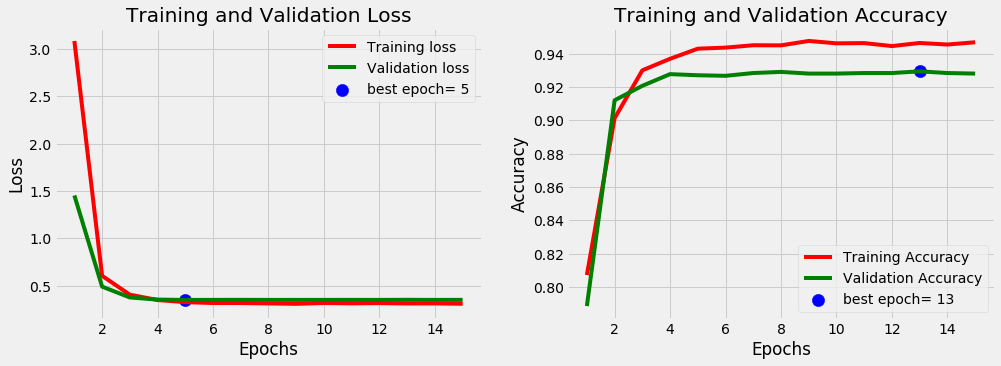

Training has completed. Now loading test set to see how accurate the model is
Instructions for updating:
Please use Model.predict, which supports generators.

 There were 219 errors in 3000 trials for an accuracy of  92.700
To see a listing of prediction errors enter Y to skip press Enter
 y
      File Name              True Class          Predicted Class        Probability
      20074.jpg                forest                glacier            61.05 
      20246.jpg                forest                mountain           93.35 
      20294.jpg                forest                mountain           88.54 
      20374.jpg                forest                mountain           69.10 
      20574.jpg                forest                mountain           85.80 
      20646.jpg                forest                mountain           59.29 
      20777.jpg                forest                mountain           58.95 
      20805.jpg                forest                mountain         

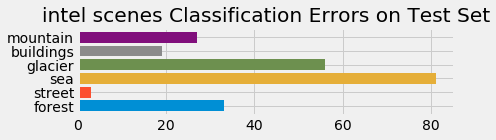

Press Enter to continue
 Test Accuracy=  0.9270 %   Training Accuracy=  0.9429 % 
Resuming training from epoch 15
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 176 steps, validate for 38 steps
Epoch 16/21
176/176 [==============================] - 170s 968ms/step - loss: 0.3122 - accuracy: 0.9446 - val_loss: 0.3499 - val_accuracy: 0.9280
Epoch 17/21
176/176 [==============================] - 171s 971ms/step - loss: 0.3082 - accuracy: 0.9464 - val_loss: 0.3502 - val_accuracy: 0.9283
Epoch 18/21
176/176 [==============================] - 176s 998ms/step - loss: 0.3062 - accuracy: 0.9474 - val_loss: 0.3500 - val_accuracy: 0.9280
Epoch 19/21
176/176 [==============================] - 175s 996ms/step - loss: 0.3168 - accuracy: 0.9448 - val_loss: 0.3502 - val_accuracy: 0.9283
Epoch 20/21
176/176 [==============================] - 171s 972ms/step - loss: 0.3090 - accuracy: 0.9471 - val_loss: 0.3501 - val_accuracy: 0.9287
Epoch 21/21
176/176 [==============================] - 170

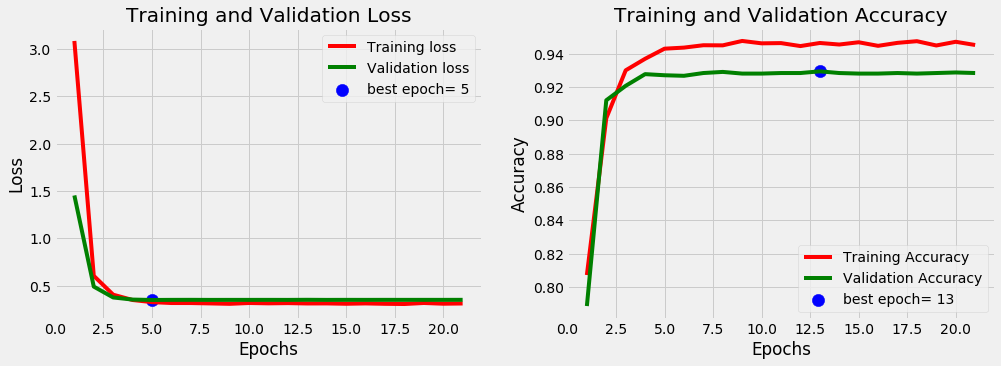

Training has completed. Now loading test set to see how accurate the model is

 There were 219 errors in 3000 trials for an accuracy of  92.700
To see a listing of prediction errors enter Y to skip press Enter
 y
      File Name              True Class          Predicted Class        Probability
      20074.jpg                forest                glacier            61.05 
      20246.jpg                forest                mountain           93.35 
      20294.jpg                forest                mountain           88.54 
      20374.jpg                forest                mountain           69.10 
      20574.jpg                forest                mountain           85.80 
      20646.jpg                forest                mountain           59.29 
      20777.jpg                forest                mountain           58.95 
      20805.jpg                forest                mountain           92.11 
      20826.jpg                forest                mountain          

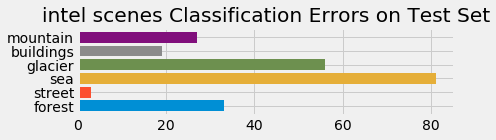

In [ ]:
TF2_classify(source_dir, output_dir, mode,subject, v_split= v_split, epochs=epochs,batch_size=batch_size,
         lr_rate= lr_rate,height=height, width=width,rand_seed=rand_seed, model_size=model_size, kaggle=False)